# Prosper loan data exploration

## Henry Owens

### Focus of the exploration: 

#### This project will look at a few elements of the Prosper loan data. I am mainly interested in the relationships between APR, credit score, ProsperRating, and loan outcome. 

#### I would like to see if there is any difference in APR or loan outcome explained by any difference in credit score and Prosper rating. I.e., does Prosper have a special advantage in giving borrowers lower rates and/or estimating losses/risks over the conventional credit bureaus. 

#### I also want to see if there are any clear relationships between some of the variables that are probably inputs into Prosper Rating (like income or debt to income ratio). The rating is proprietary and very complex, but maybe I can reverse engineer it just a little bit. (Spoiler alert: Nope).

#### NOTE: I accidentally did not use the template and just started a blank workbook. I include lots of questions, reflections, revelations, etc.


### Preliminary Assessment of the data

There are 113937 rows, and 81 columns. Many of these are fully populated. I am interested in only only a handful of columns and only rows where loans with both a credit score, prosper rating and debt to income ratio which is about 77000 of the rows. Prosper had a different rating system before 2009. And I guess they do not always get debt to income. 


NOTE: As I did this project, I had to reiterate the assessing and cleaning steps, so much of that happens below.
    
    Credit score is given as two numbers high and low, the scores are divided into bins basically. 
    The actual credit score is not given precisely.
    Listing category is a numeric corresponding to list of categories
    Loan term is really just 3 options: 12, 36 or 60 months
    Many rows do not have the relevant Prosper Score 
    Many rows do not have debt to income

In general the data is mostly clean and tidy. I will do some cleaning now and some re-cleaning along the way.

In [1]:
# importing packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# Load the dataframe and assess
dfloan = pd.read_csv('prosperLoanData.csv')
dfloan.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


#### I am curious: what time frame does this data set cover? 
   #### November 2005 to March 2014

In [3]:
dfloan.ListingCreationDate.min(), dfloan.ListingCreationDate.max()

('2005-11-09 20:44:28.847000000', '2014-03-10 12:20:53.760000000')

In [4]:
# Assessing the credit score upper/lower:
dfloan['creddiffs'] = dfloan.CreditScoreRangeUpper - dfloan.CreditScoreRangeLower 
dfloan.creddiffs.describe()

count    113346.0
mean         19.0
std           0.0
min          19.0
25%          19.0
50%          19.0
75%          19.0
max          19.0
Name: creddiffs, dtype: float64

#### Tidying up the credit score

##### The difference between credit score upper and lower for every row is 19. So I will just use the upper score and eliminate the lower. I wish they had exact scores.

In [5]:
# Picking out the columns for a new data frame subset 'dfloan2'

cols = ['Term', 'LoanOriginalAmount', 'LoanStatus', 'BorrowerAPR', 'ProsperRating (Alpha)', 
        'CreditScoreRangeUpper', 'ListingCategory (numeric)', 'StatedMonthlyIncome', 
        'DebtToIncomeRatio']
dfloan2 = dfloan[cols]
dfloan2.head()

,Term,LoanOriginalAmount,LoanStatus,BorrowerAPR,ProsperRating (Alpha),CreditScoreRangeUpper,ListingCategory (numeric),StatedMonthlyIncome,DebtToIncomeRatio
0,36,9425,Completed,0.16516,NaN,659.0,0,3083.333333,0.17
1,36,10000,Current,0.12016,A,699.0,2,6125.000000,0.18
2,36,3001,Completed,0.28269,NaN,499.0,0,2083.333333,0.06
3,36,10000,Current,0.12528,A,819.0,16,2875.000000,0.15
4,36,15000,Current,0.24614,D,699.0,2,9583.333333,0.26


In [6]:
# Rename columns for ease of handling
colnames = {'LoanOriginalAmount': 'loanamount', 'LoanStatus': 'loanstatus', 'BorrowerAPR': 'apr', 'ProsperRating (Alpha)': 'prosperrating', 
        'ListingCategory (numeric)': 'loancategory', 'CreditScoreRangeUpper': 'creditscore',
            'StatedMonthlyIncome': 'income', 'DebtToIncomeRatio': 'debttoincome'}
dfloan2 = dfloan2.rename(columns = colnames)

In [7]:
# make column headers lowercase

dfloan2.columns = map(str.lower, dfloan2.columns)
dfloan2.head()

,term,loanamount,loanstatus,apr,prosperrating,creditscore,loancategory,income,debttoincome
0,36,9425,Completed,0.16516,NaN,659.0,0,3083.333333,0.17
1,36,10000,Current,0.12016,A,699.0,2,6125.000000,0.18
2,36,3001,Completed,0.28269,NaN,499.0,0,2083.333333,0.06
3,36,10000,Current,0.12528,A,819.0,16,2875.000000,0.15
4,36,15000,Current,0.24614,D,699.0,2,9583.333333,0.26


In [8]:
# Dropping rows where prosper rating and credit score are null
dfloan2 = dfloan2[dfloan2.prosperrating.notna()]
dfloan2 = dfloan2[dfloan2.creditscore.notna()]
dfloan2 = dfloan2[dfloan2.debttoincome.notna()]
dfloan2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77557 entries, 1 to 113936
Data columns (total 9 columns):
term             77557 non-null int64
loanamount       77557 non-null int64
loanstatus       77557 non-null object
apr              77557 non-null float64
prosperrating    77557 non-null object
creditscore      77557 non-null float64
loancategory     77557 non-null int64
income           77557 non-null float64
debttoincome     77557 non-null float64
dtypes: float64(4), int64(3), object(2)
memory usage: 5.9+ MB


In [9]:
# Credit score to int
dfloan2.creditscore = dfloan2.creditscore.astype('int')

In [10]:
# Convert prosper rating into ordered categorical type
rating_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = rating_order)
dfloan2.prosperrating = dfloan2.prosperrating.astype(ordered_var);

In [11]:
# Converting loan category numbers to text descriptions and converting to category

category_dict = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 4: 'Personal Loan',
                 5: 'Student Use', 6: 'Auto', 7:'Other', 8: 'Baby&Adoption', 9: 'Boat', 10: 'Cosmetic Procedure', 
                 11: 'Engagement Ring', 12: 'Green Loans', 13: 'Household Expenses', 14: 'Large Purchases', 
                 15: 'Medical/Dental', 16: 'Motorcycle', 17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding Loans'}
dfloan2.loancategory.replace(category_dict, inplace=True)
dfloan2.loancategory = dfloan2.loancategory.astype('category')

In [12]:
# Simplifying some of the loan statuses so there are fewer groups 
# I converted these to ordered categories, but it made lots of trouble when i made a 
# new data frame of a selection of rows based on status during Bivariate Analysis. 
# Also it was not absolutely necessary to have these in ordered category format.

status_dict = {'Past Due (31-60 days)': 'Past Due (16-60 days)',
       'Past Due (91-120 days)': 'Past Due (>60 days)', 'Past Due (61-90 days)': 'Past Due (>60 days)',
       'Past Due (16-30 days)': 'Past Due (16-60 days)', 'FinalPaymentInProgress': 'Current',
       'Past Due (>120 days)': 'Past Due (>60 days)'}
dfloan2.loanstatus.replace(status_dict, inplace=True)


In [13]:
dfloan2.describe()

,term,loanamount,apr,creditscore,income,debttoincome
count,77557.000000,77557.000000,77557.00000,77557.000000,77557.000000,77557.000000
mean,42.724035,9269.314208,0.22373,717.999446,5963.503215,0.258752
std,11.711915,6398.380615,0.07916,47.160646,5082.144391,0.318326
min,12.000000,1000.000000,0.04583,619.000000,0.250000,0.000000
25%,36.000000,4000.000000,0.16175,679.000000,3533.333333,0.150000
50%,36.000000,8000.000000,0.21566,719.000000,5000.000000,0.220000
75%,60.000000,14500.000000,0.28780,739.000000,7166.666667,0.320000
max,60.000000,35000.000000,0.42395,899.000000,483333.333333,10.010000


# Univariate Analysis

Starting with histograms of the numerical variables: Loan amount, APR, stated monthly income, debt to income and credit score.

In [14]:
dfloan2.describe()

,term,loanamount,apr,creditscore,income,debttoincome
count,77557.000000,77557.000000,77557.00000,77557.000000,77557.000000,77557.000000
mean,42.724035,9269.314208,0.22373,717.999446,5963.503215,0.258752
std,11.711915,6398.380615,0.07916,47.160646,5082.144391,0.318326
min,12.000000,1000.000000,0.04583,619.000000,0.250000,0.000000
25%,36.000000,4000.000000,0.16175,679.000000,3533.333333,0.150000
50%,36.000000,8000.000000,0.21566,719.000000,5000.000000,0.220000
75%,60.000000,14500.000000,0.28780,739.000000,7166.666667,0.320000
max,60.000000,35000.000000,0.42395,899.000000,483333.333333,10.010000


### APR and Loan 
Loan amounts cluster around \$5k intervals. APR is somewhat normally distributed around 20%, but there is a major spike at 35%, the most frequent value.

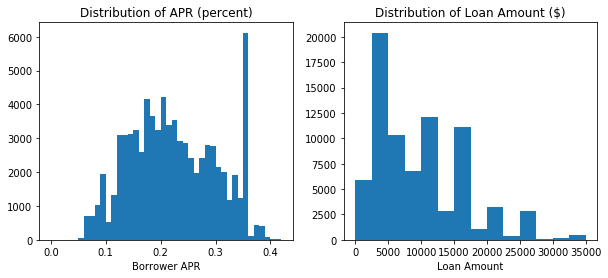

In [15]:
# Plotting distribution of APR and Loan amount

plt.figure(figsize = [10,4]) # larger figure size for subplots


plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
bins = np.arange(0, dfloan2.apr.max()+0.005, 0.01)
plt.hist(data = dfloan2, x = 'apr', bins = bins);
plt.title('Distribution of APR (percent)')
plt.xlabel('Borrower APR')

plt.subplot(1, 2, 2)
bins = np.arange(0, dfloan2.loanamount.max()+2500, 2500)
#plt.figure(figsize=[8, 6])
plt.hist(data = dfloan2, x = 'loanamount', bins=bins);
plt.title('Distribution of Loan Amount ($)')
plt.xlabel('Loan Amount');

### Credit Score

#### Credit score (I used upper because they were just ranges) only goes down to 619, which leaves out the classic 'subprime' group of consumer borrowers. But otherwise it looks pretty nicely distributed with a right skew.

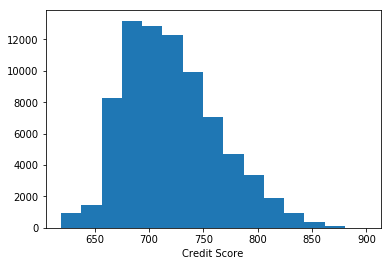

In [16]:
# Distribution of credit score
# the data set breaks the credit scores into chunks of twenty. And all of the rows with a 
# Prosper rating have a credit score upper of 619 or higher. 
bins = len(dfloan2.creditscore.value_counts())

plt.hist(data=dfloan2, x='creditscore', bins=bins)
plt.xlabel('Credit Score');

### Monthly Stated Income and Debt to Income Ratios

#### In the income and debt to income values there are some major outliers, which i deal with below, after plotting the histograms with and without the outliers.

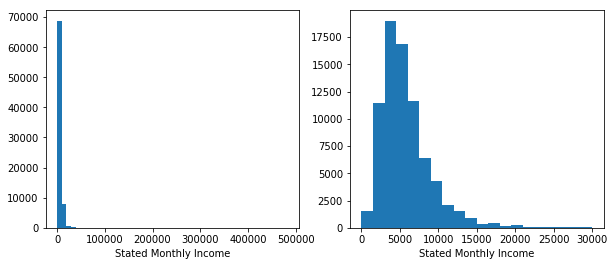

In [17]:
# There are some major outliers in the stated monthly income values (max is $483k per month)
# limiting the hist to $30k and below
plt.figure(figsize = [10,4])

#bins = np.arange(0, dfloan2.income.max()+1, 5000)
plt.subplot(1,2,1)
plt.hist(data=dfloan2, x='income', bins=50)
plt.xlabel('Stated Monthly Income')

plt.subplot(1,2,2)
plt.hist(data=dfloan2[dfloan2.income <=30000], x='income', bins=20)
plt.xlabel('Stated Monthly Income');

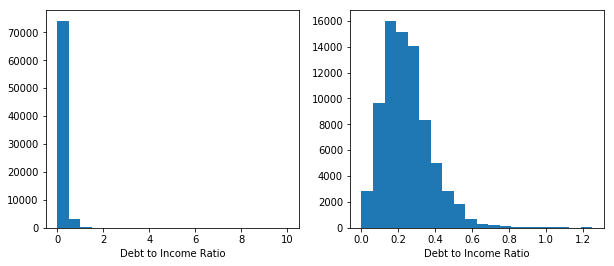

In [18]:
# Debt to income has some outliers too. They do not report over 1001% of income. and some of
# those rows look silly, as in monthly income is only in the double digits
plt.figure(figsize=[10,4])
#bins = [0, 10.5, 0.5]
#np.arange(0, dfloan2.debttoincome.max()+0.01, 1)
plt.subplot(1,2,1)
plt.hist(data=dfloan2,x='debttoincome', bins=20)
plt.xlabel('Debt to Income Ratio');

# Limiting the hist here to below 1.25 and capturing most of everything.
plt.subplot(1,2,2)
plt.hist(data=dfloan2[dfloan2.debttoincome <=1.25],x='debttoincome', bins=20)
plt.xlabel('Debt to Income Ratio');

In [19]:
# I can eliminate these rows and barely lose any of the data

print('Percent of rows with DTI over 1.25:', 
      len(dfloan2[dfloan2.debttoincome > 1.25])/len(dfloan2))
print('Percent of rows with monthly income over $30k:', 
      len(dfloan2[dfloan2.income > 30000])/len(dfloan2))

Percent of rows with DTI over 1.25: 0.0025916422760034557
Percent of rows with monthly income over $30k: 0.002462704849336617


In [20]:
# Dropping rows with outlier values in DTI and income. 
dfloan2 = dfloan2[dfloan2.debttoincome <= 1.25]
dfloan2 = dfloan2[dfloan2.income <= 30000]

In [21]:
dfloan2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77165 entries, 1 to 113936
Data columns (total 9 columns):
term             77165 non-null int64
loanamount       77165 non-null int64
loanstatus       77165 non-null object
apr              77165 non-null float64
prosperrating    77165 non-null category
creditscore      77165 non-null int64
loancategory     77165 non-null category
income           77165 non-null float64
debttoincome     77165 non-null float64
dtypes: category(2), float64(3), int64(3), object(1)
memory usage: 4.9+ MB


### Loan Term and Prosper Rating

#### As mentioned before, there must only be three options for loan term at Prosper, one year, three years, five years.
#### The distribution of Prosper Ratings falls pretty evenly around the peak in the middle score of  'C'. That is good so we can assess a fairly even number of safe and risky borrowers.

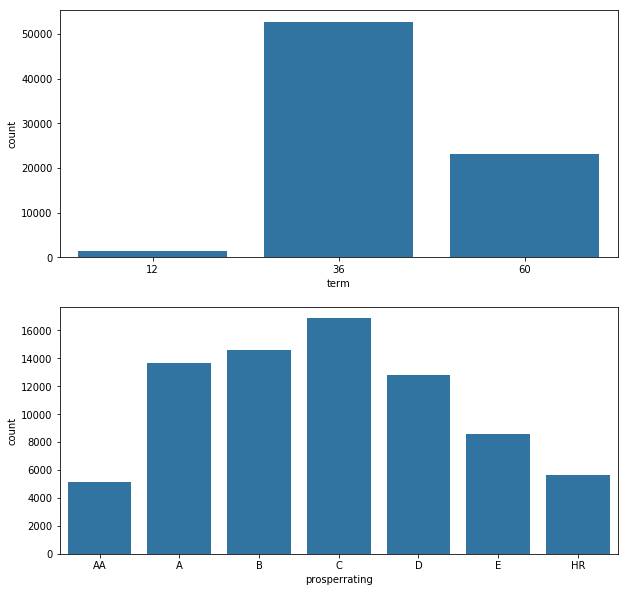

In [22]:
# Plotting two of the categorical variables: Loan term and Prosper Rating

fig, ax = plt.subplots(nrows=2, figsize = [10,10])
base_color = sb.color_palette()[0]
sb.countplot(data = dfloan2, x = 'term', color = base_color, ax = ax[0])
sb.countplot(data = dfloan2, x = 'prosperrating', color = base_color, ax = ax[1]);
#sb.countplot(data = dfloan2, x = 'loanstatus', color = base_color, ax = ax[2]);
#sb.countplot(data = dfloan2, x = 'loancategory', color = base_color, ax = ax[2]);
#plt.xticks(rotation=30);

### Why are people borrowing from Prosper? And how are they doing on repayment?

#### These plots show the counts of loan category and loan status. The vast majority of borrowers are using the proceeds of Prosper loans to pay off other debt. Some is business, but it must be very small business given the small value of the loans. 

#### I will want to see if there are relationships between these and other vars. The majority of loans are for debt consolidation and are either current or completed.


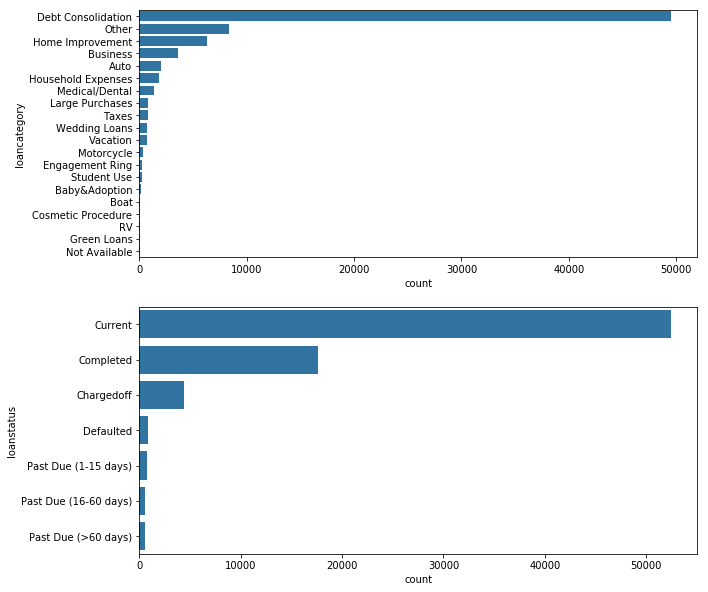

In [23]:
# Plotting the loan category and loan status with horizontal count plot

fig, ax = plt.subplots(nrows=2, figsize = [10,10])
#dfloan2.term.groupby(dfloan2.loancategory).count().plot(kind='bar', ) 
base_color = sb.color_palette()[0]
cat_order = dfloan2['loancategory'].value_counts().index
sb.countplot(data = dfloan2, y = 'loancategory', color = base_color, order=cat_order,
            ax=ax[0])
stat_order = dfloan2['loanstatus'].value_counts().index
sb.countplot(data = dfloan2, y = 'loanstatus', color = base_color, order=stat_order,
             ax = ax[1]);

### Credit Score and Prosper Rating side by side

#### I wanted to get a peak at credit score and Prosper ratings side by side. I do not quite know how the credit scores and Prosper Ratings translate, but here you can see the peak of credit score is around 700 with significant right skew, while the peak for Prosper Rating is 'C' without too much skew.

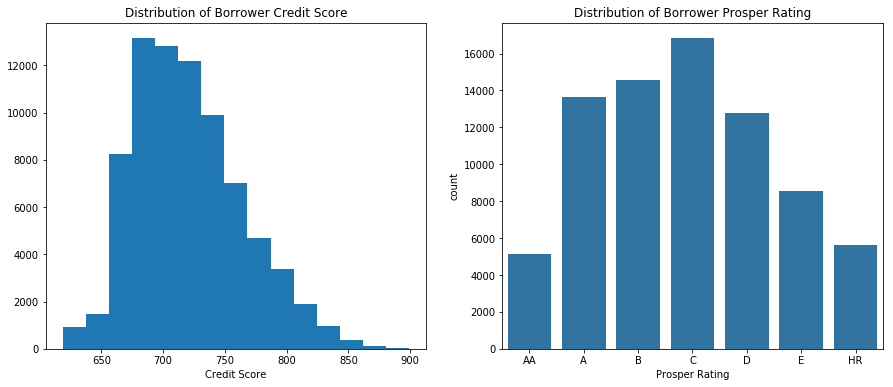

In [24]:
# Comparing dist of credit score to prosper rating

plt.figure(figsize=[15, 6])
#dfloan2.term.groupby(dfloan2.loancategory).count().plot(kind='bar', ) 
plt.subplot(1,2,1)
bins = len(dfloan2.creditscore.value_counts())
plt.hist(data=dfloan2, x='creditscore', bins=bins)
plt.xlabel('Credit Score')
plt.title('Distribution of Borrower Credit Score')

plt.subplot(1,2,2)
#rating_order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
sb.countplot(data = dfloan2, x = 'prosperrating', color = base_color)
plt.xlabel('Prosper Rating')
plt.title('Distribution of Borrower Prosper Rating');

# Bivariate analysis
#### Now we get to look at the interactions of variables. 

In [25]:
# bundling the num and cat vars
numvars = ['loanamount', 'apr', 'income', 'debttoincome', 'creditscore']
catvars = ['prosperrating', 'term', 'loanstatus', 'loancategory']

### What are the relationships between quantitative variables?

The strongest correlation among these variables is the negative relationship between credit score and APR which is intuitive but nontrivial. Higher credit score means lower credit risk and lower interest rate for the borrower.

Some other relationships I thought would be more pronounced, but do not appear to be here are income to APR and debt-to-income to APR. I guess I thought that DTI was a big factor in the lending decision, meaning that DTI and APR would be more positively correlated. R squared of 0.2 is pretty low though. 

I also thought that the lowest income people usually carried pretty low debt*, but among this population of borrowers, there is a strong relationship the other way. I guess since most borrowers are using their loans for debt consolidation this is a more highly debt burdened sub-population than the wider population. 

* this is true for student loans, https://www.urban.org/urban-wire/which-households-hold-most-student-debt

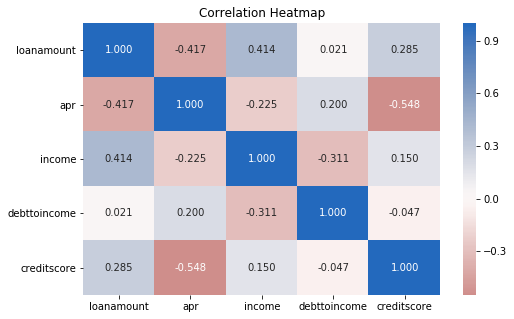

In [26]:
# plotting correlation for numerical variables
plt.figure(figsize = [8, 5])
sb.heatmap(dfloan2[numvars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.title('Correlation Heatmap');

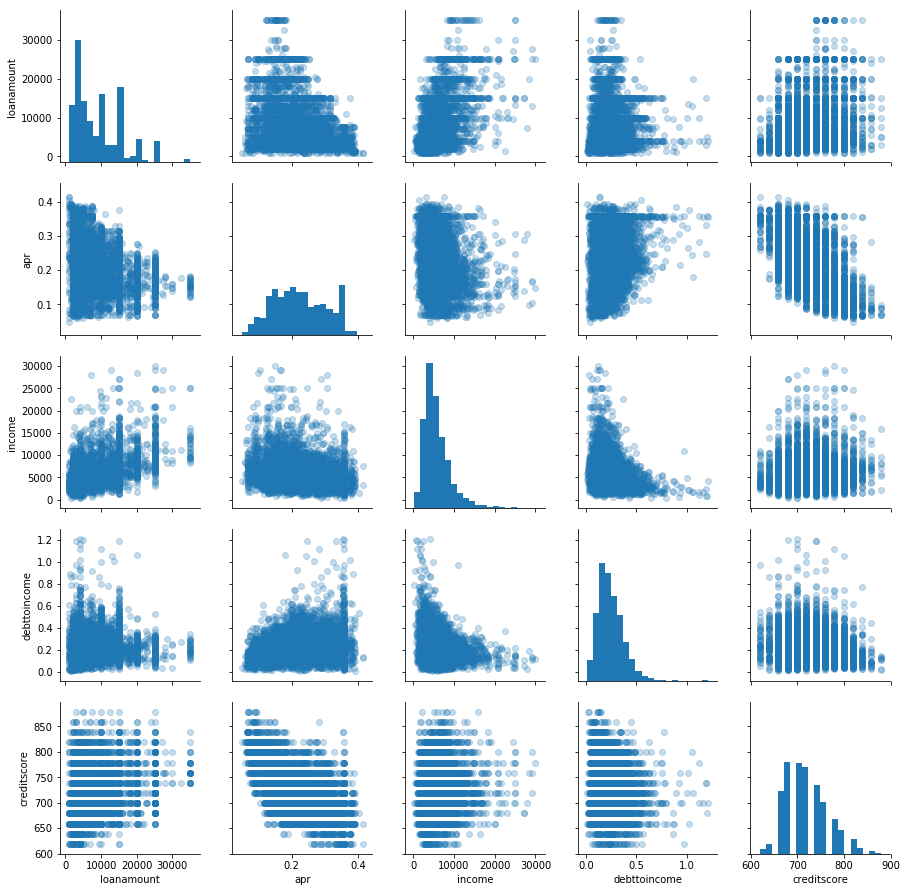

In [27]:
# plot matrix using a sample of 5000 loans for clarity and speed of processing
dfsample = dfloan2.sample(5000)
g = sb.PairGrid(data = dfsample.dropna(), vars = numvars)
g = g.map_diag(plt.hist, bins=20)
g.map_offdiag(plt.scatter, alpha= 1/4);

### What are the major interactions among the categorical variables?

#### The biggest thing here is the relationship between Prosper Rating and APR. There is also a relationship between Prosper Rating and credit score, as expected. Loan term and loan amount are positively related: longer term loans are bigger in value. I will have to pull out some of these to assess further.

/Users/henrybowens/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


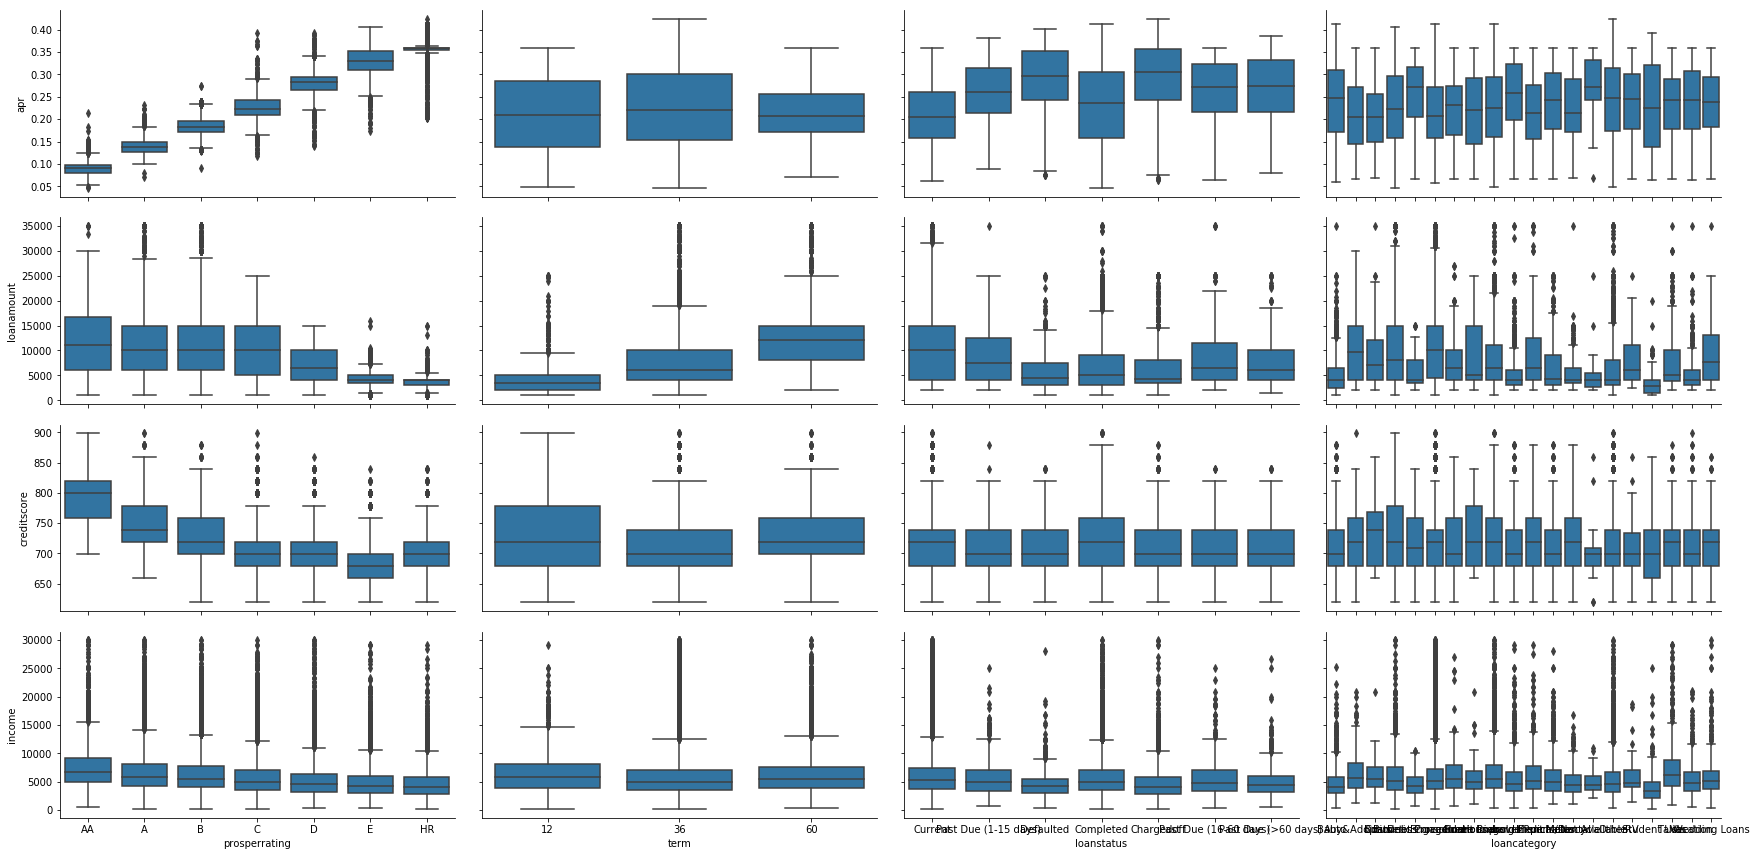

In [28]:
# ELIM?

# plot matrix of numeric features against categorical features.

def grid(x, y, **kwargs):
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

g = sb.PairGrid(data = dfloan2, y_vars = ['apr', 'loanamount', 'creditscore', 'income'], 
                x_vars = catvars, size = 3, aspect = 2)
g.map(grid);

### How does APR map onto Prosper Rating? Very Closely!!

#### Relationship between APR and Prosper rating shows clearly that riskier borrowers pay higher rates. 

(I did a box plot and violin plot just to explore the features)
 

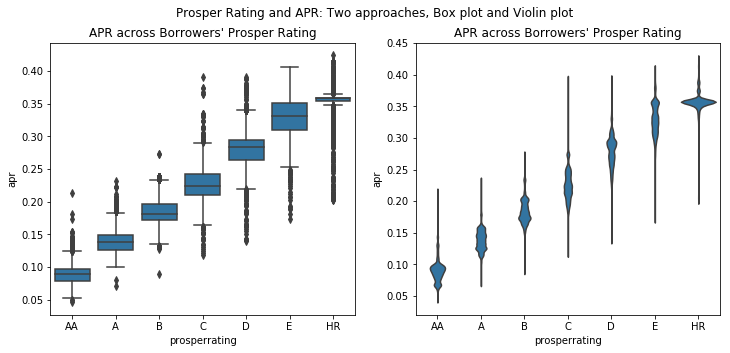

In [29]:
# A closer look at the relationship between Prosper Rating and APR: 
# it seems likely that prosper rating is a big determinant of APR
fig = plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
base_color = sb.color_palette()[0]
sb.boxplot(data = dfloan2, x = 'prosperrating', y = 'apr', color=base_color)
plt.title('APR across Borrowers\' Prosper Rating')

plt.subplot(1,2,2)
sb.violinplot(data = dfloan2, x = 'prosperrating', y = 'apr', color=base_color, 
             inner = None)
plt.title('APR across Borrowers\' Prosper Rating')

fig.suptitle('Prosper Rating and APR: Two approaches, Box plot and Violin plot');

### How big of a deal is Debt to income in the Prosper Rating?

#### Prosper Rating and Debt to income shows a pretty subtle relationship, with high risk borrowers only have a slightly higher mean DTI than AA borrowers (about  0.25 compared to about 0.18). The upper quartile range is much higher for C through HR than for AA. 
I really thought that prosper rating and debt to income would have a stronger relationship, but apparently not!

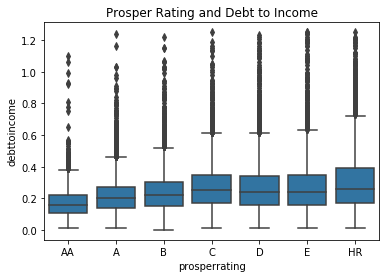

In [30]:
# P Rating and DTI? 
base_color = sb.color_palette()[0]
sb.boxplot(data = dfloan2, x = 'prosperrating', y = 'debttoincome', color=base_color)
plt.title('Prosper Rating and Debt to Income');

### How does Prosper Rating compare to Credit Score?

#### Prosper rating and Credit score: Top three Prosper rating groups have increasing credit scores, but the 'C' to 'HR' rating groups have similar the same credit scores.

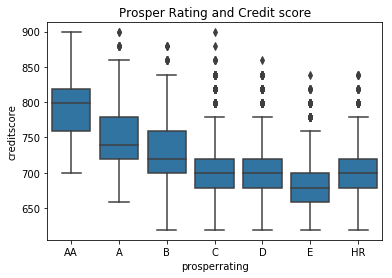

In [31]:
# P Rating and credit score?
base_color = sb.color_palette()[0]
sb.boxplot(data = dfloan2, x = 'prosperrating', y = 'creditscore', color=base_color)
plt.title('Prosper Rating and Credit score');

### Do credit scores track with loan outcomes? Not really...

#### Credit Score mean is higher for current and completed loans. Interestingly the interquartile ranges, mins and maxs are virtually identical for all but the completed group. I would think that defaulted/late payment loans would have way lower credit ratings, but about half of them have "good" credit scores of 700+.  

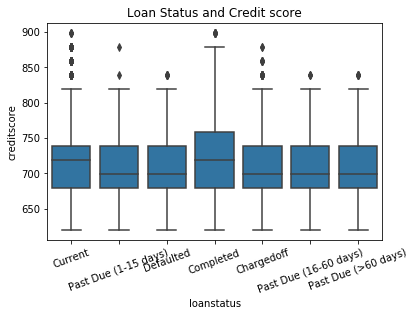

In [32]:
# credit score and loan status
base_color = sb.color_palette()[0]
sb.boxplot(data = dfloan2, x = 'loanstatus', y = 'creditscore', color=base_color)
plt.title('Loan Status and Credit score')
plt.xticks(rotation=20);

In [33]:
dfloan_notgood = dfloan2[dfloan2.loanstatus != 'Current']
dfloan_notgood = dfloan_notgood[dfloan_notgood.loanstatus != 'Completed']

In [34]:
dfloan_notgood.loanstatus.value_counts()

Chargedoff               4403
Defaulted                 878
Past Due (1-15 days)      718
Past Due (16-60 days)     566
Past Due (>60 days)       558
Name: loanstatus, dtype: int64

In [35]:
# Convert loan status into ordered categorical type
status_order = ['Past Due (1-15 days)', 'Past Due (16-60 days)', 
                'Past Due (>60 days)', 'Defaulted', 'Chargedoff']
ordered_var_status = pd.api.types.CategoricalDtype(ordered = True, categories = status_order)
dfloan_notgood.loanstatus = dfloan_notgood.loanstatus.astype(ordered_var_status);

### How do the loan status outcomes break down by Prosper Rating?

#### This indicates that, as measured by Prosper Rating, the higher risk borrowers defaulted and had their loans charged off more often. 

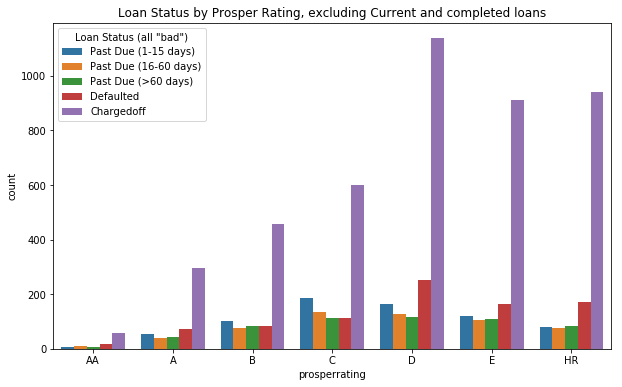

In [36]:
# What are the loan outcomes across different prosper ratings? Most of the loans are current 
# or otherwise in good standing, so i am omitting those here.
plt.figure(figsize = [10, 6])


#plt.subplot(2,1,1)
sb.countplot(data = dfloan_notgood, x = 'prosperrating', hue = 'loanstatus');
plt.title('Loan Status by Prosper Rating, excluding Current and completed loans')
plt.legend(title='Loan Status (all "bad")');
#plt.subplot(2,1,2)
#sb.countplot(data = dfloan2, x = 'prosperrating', hue = 'loanstatus')
#plt.title('Loan Status by Prosper Rating');

### Does Prosper have a "secret sauce" in their Ratings? 

#### This is my favorite chart I was able to make. It shows the distributions of prosper rating and credit score for the 'bad' loan categories as a percent of 'bad' loans. This allows for some comparison, even though the ratings/scores are different. It shows that the Prosper Rating and Credit Score have similar relationships with 'bad' loan outcomes. 

#### It's not obvious that Prosper is doing a signifincantly better job at credit assessment with its rating than the credit bureaus, since over 10 percent of all bad loans that were charged off had 'AA', 'A,' or 'B' ratings. If the Prosper Ratings had more left skew then you could conclude that they were doing better, but it is hard to say if one is better based on this comparison. 


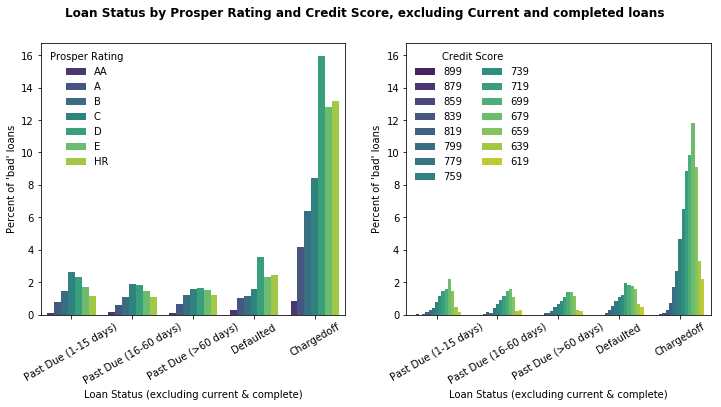

In [37]:
# I found a way to get the distribution of the PERCENT of loans in a certain status, 
# broken down by prosper score and rating. I use income as the y variable just because 
# it needs a numerical variable. 

fig = plt.figure(figsize=[12,5])

ax1 = plt.subplot(1,2,1)
ax1 = sb.barplot(x="loanstatus", y="income", data=dfloan_notgood, 
                estimator=lambda x: len(x) / len(dfloan_notgood) * 100, hue='prosperrating',
                palette='viridis')
ax1.set(ylabel="Percent of 'bad' loans", xlabel='Loan Status (excluding current & complete)')
plt.xticks(rotation=30)
ax1.legend(title='Prosper Rating', frameon=False,)

score_order = dfloan2.creditscore.value_counts().index.sort_values(ascending=False)

ax2 = plt.subplot(1,2,2, sharey=ax1)
ax2 = sb.barplot(x="loanstatus", y="income", data=dfloan_notgood, 
                estimator=lambda x: len(x) / len(dfloan_notgood) * 100, hue='creditscore',
               palette='viridis', hue_order=score_order)
ax2.set(ylabel="Percent of 'bad' loans", xlabel='Loan Status (excluding current & complete)')
plt.xticks(rotation=30)
ax2.legend(title='Credit Score', frameon=False, ncol=2)


fig.suptitle('Loan Status by Prosper Rating and Credit Score, excluding Current and completed loans',

             
             fontweight='bold');

### Could Prosper use Credit Score to calculate APR?

#### Plotting the credit score and APR shows a pretty clear correlation between the two: higher credit score is associated with lower APR. Maybe they could skip the Prosper Rating and just use the credit scores, but then the data scientists would have nothing to do!

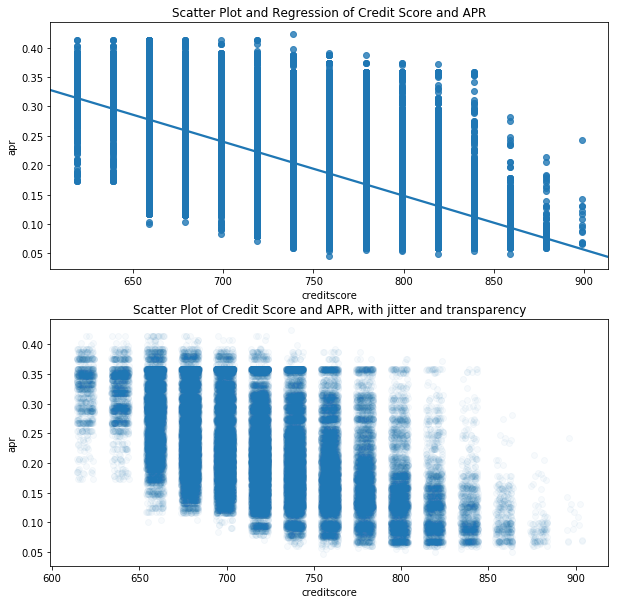

In [38]:
# Credit score and APR

plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
sb.regplot(data = dfloan2, x = 'creditscore', y = 'apr')
plt.title('Scatter Plot and Regression of Credit Score and APR')

plt.subplot(2,1,2)
sb.regplot(data = dfloan2, x = 'creditscore', y = 'apr', fit_reg = False,
           x_jitter = 5, scatter_kws = {'alpha' : 1/30})
plt.title('Scatter Plot of Credit Score and APR, with jitter and transparency');

### Do riskier borrowers borrow less? Or does Prosper just not trust them as much?

#### This plot is funny because the loan increments get bigger as the loan value increases. I would imagine risky borrowers are only allowed to take small dollar loans, so the relationship goes both ways.

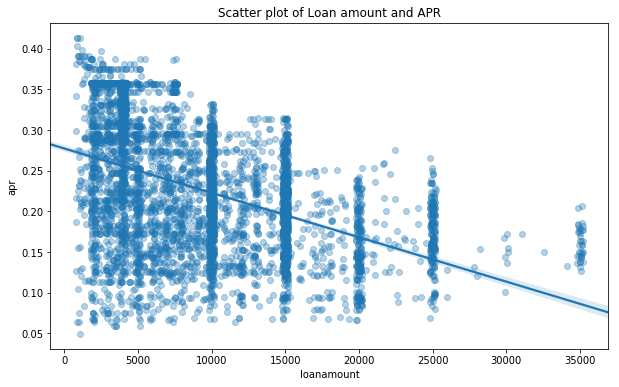

In [39]:
# using a sample with jitter and transparency to plot loan amount and APR

plt.figure(figsize=[10,6])
df_sample = dfloan2.sample(5000)
sb.regplot(data = df_sample, x = 'loanamount', y = 'apr',
           x_jitter = 200, scatter_kws = {'alpha' : 1/3})
plt.title('Scatter plot of Loan amount and APR');

# Multivariate Analysis

#### Using multivariate analysis, I want to see if I can pull out any relationships between the numerical variables, Prosper Rating, loan status and listing category. Maybe there is a sub-grouping that will reverse the relationship of the main variables. 


### How important is DTI in Prosper Rating and APR?

#### As we saw earlier, there is no obvious pattern of DTI and APR/Rating, but here we can tease out a slight pattern of increasing DTI for the higher risk borrowers. Low DTI will not prevent the lender from charging a high rate, but it does seem like a prerequisite for a good Prosper Rating: it looks like most of the 'AA' borrowers have DTI below 0.25. But then again so do plenty of all the other borrowers. 


### What is with all of the 36% APRs?
#### One thing that has popped up in all the APR charts is the cluster of values at 36%. It turns out that 36% is the cap on certain consumer interest rates in 15 states and DC: 

    Why 36%? The History, Use, and Purpose of the 36% Interest Rate Cap, Lauren K. Saunders, National Consumer Law Center. 
    https://www.nclc.org/images/pdf/pr-reports/why36pct.pdf



/Users/henrybowens/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


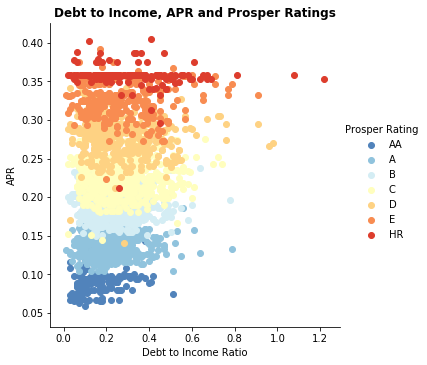

In [40]:
# Plotting rating, DTI and APR. Using sample to 
dfsample = dfloan2.sample(2500)
# see Udacity DAND Multivariate lesson, section #3: Color Palettes

g = sb.FacetGrid(data = dfsample, hue = 'prosperrating', size = 5, palette='RdYlBu_r')
g.map(plt.scatter, 'debttoincome', 'apr', alpha=1)
g.add_legend(title='Prosper Rating')
plt.title('Debt to Income, APR and Prosper Ratings', fontweight="bold")
plt.xlabel('Debt to Income Ratio')
plt.ylabel('APR');

### What relationships exist among subgroups of categorical variables?

#### These plots show pretty tight relationships among the loan status subgroups of the prosper rating levels across different numerical variables. 

I think the one interesting thing here is that the because of small sample size, the error bars show greater uncertainty about values in the 'AA' rating, especially the poorly performing ones (past due, defaulted, etc). However the bars do not indicate uncertainty (i.e., small sample size) about the strongly performing classes of loans in the 'HR' rating group. Indicating that there are plenty of current loans in the high risk group.


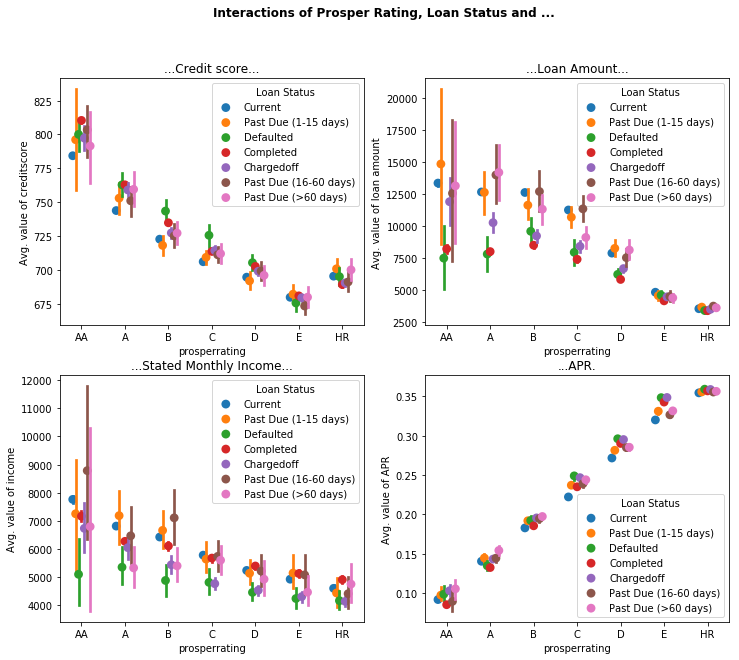

In [41]:
# plotting Prosper rating, loan status, and cat vars.

fig = plt.figure(figsize=[12,10])

plt.subplot(2,2,1)
sb.pointplot(data = dfloan2, x = 'prosperrating', y = 'creditscore', hue='loanstatus', 
             dodge = 0.4, linestyles = "")
plt.ylabel('Avg. value of creditscore')
plt.title('...Credit score...')
plt.legend(title='Loan Status')

plt.subplot(2,2,2)
sb.pointplot(data = dfloan2, x = 'prosperrating', y = 'loanamount', hue='loanstatus', 
             dodge = 0.4, linestyles = "")
plt.ylabel('Avg. value of loan amount')
plt.title('...Loan Amount...')
plt.legend(title='Loan Status')


plt.subplot(2,2,3)
sb.pointplot(data = dfloan2, x = 'prosperrating', y = 'income', hue='loanstatus', 
             dodge = 0.4, linestyles = "")
plt.ylabel('Avg. value of income')
plt.title('...Stated Monthly Income...')
plt.legend(title='Loan Status')


plt.subplot(2,2,4)
sb.pointplot(data = dfloan2, x = 'prosperrating', y = 'apr', hue='loanstatus', 
             dodge = 0.4, linestyles = "")
plt.ylabel('Avg. value of APR')
plt.title('...APR.')
plt.legend(title='Loan Status')
fig.suptitle('Interactions of Prosper Rating, Loan Status and ...', fontweight="bold");

### Does loan category impact APR?

#### I wanted to see if the category of loan would have any impact on the APR. Here I plotted APR, income and loan category, but they all have a negative correlation. I thought maybe that loans for "indulgent" things would be penalized with higher rates. By far, most of the loans are for debt consolidation, and most of the other categories have very few data points. 

/Users/henrybowens/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


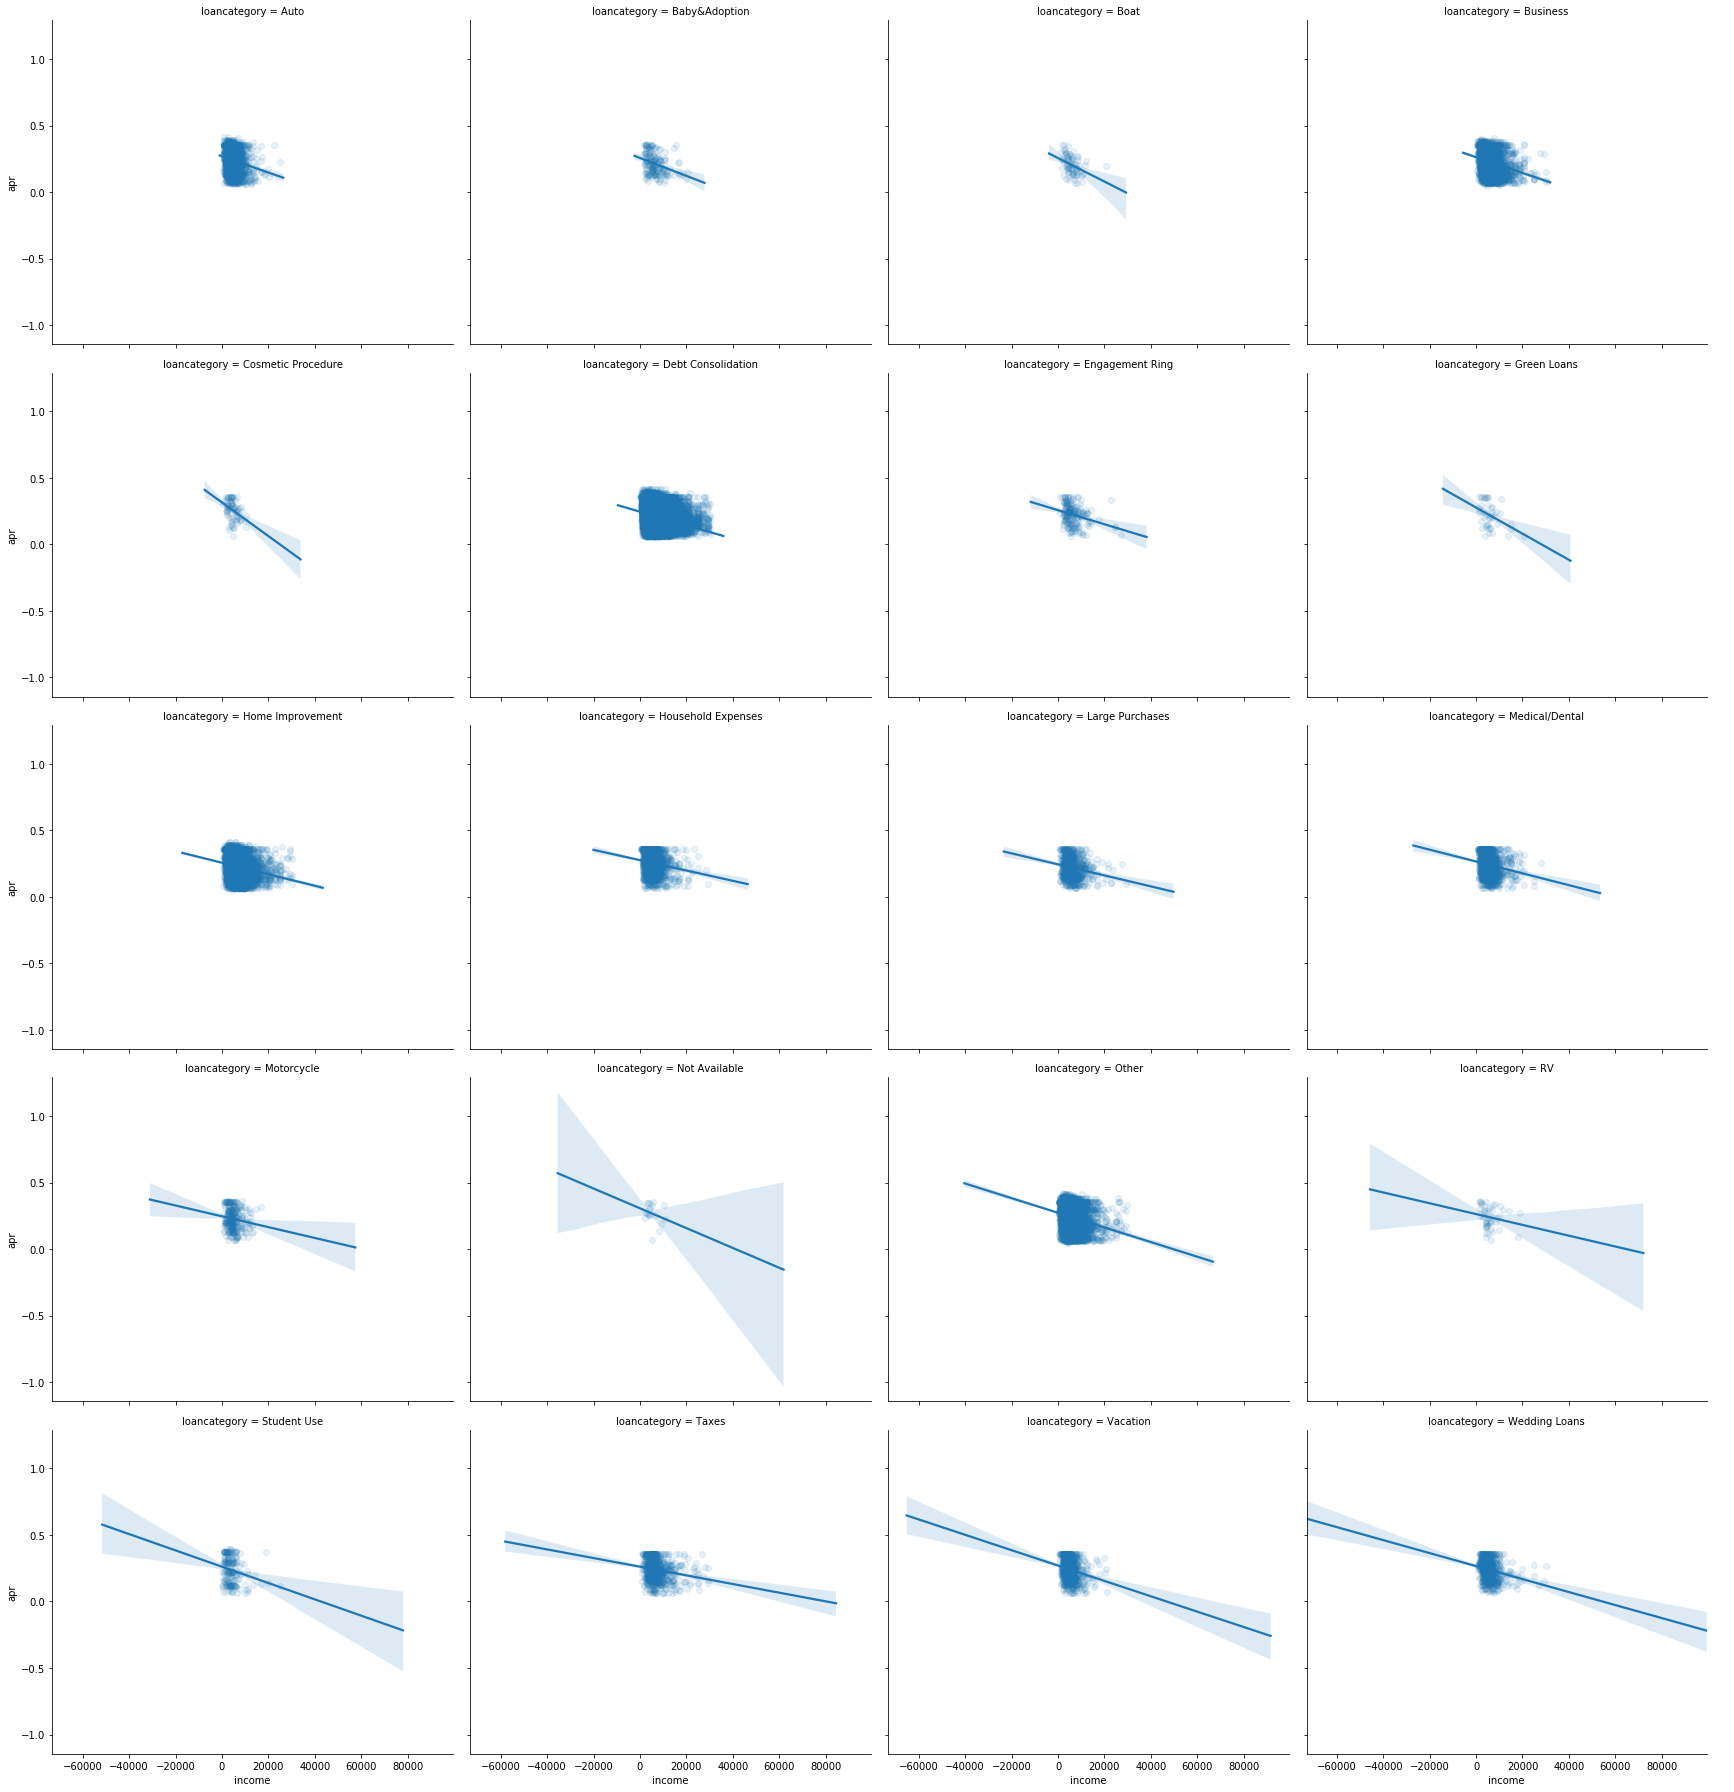

In [42]:
#dfsample = dfloan2.sample(5000)

g=sb.FacetGrid(data=dfloan2, aspect=1.2, size=5, col='loancategory', col_wrap=4)
g.map(sb.regplot, 'income', 'apr', x_jitter=0.04, scatter_kws={'alpha':0.1});
g.add_legend();

/Users/henrybowens/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/henrybowens/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


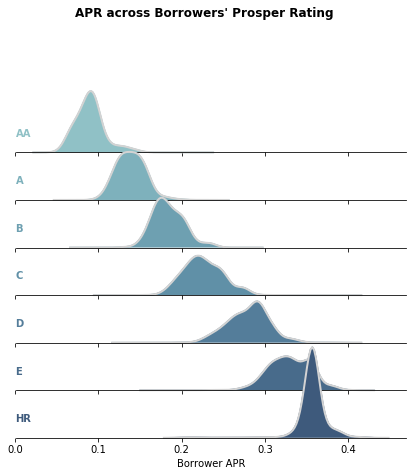

In [43]:
# I spent a lot of time making this ridge line plot to look nice, but it is not perfect.
# This was built mainly from the ridgeline extra lesson and this website:
#    https://seaborn.pydata.org/examples/kde_ridgeplot.html
# It really helped to reset the bandwidth (bw) in the KDE helped bring up the curves. 
# Found this in the seaborn documentation:
#    https://seaborn.pydata.org/tutorial/distributions.html

group_means = dfloan2.groupby(['prosperrating']).mean()
group_order = group_means.sort_values(['apr']).index

pal = sb.cubehelix_palette(10, rot=-.25, light=.7)
g = sb.FacetGrid(data = dfloan2, row = 'prosperrating', hue='prosperrating', size = 1, 
                 aspect = 7,row_order = group_order, palette=pal, 
                 gridspec_kws = {'hspace' : -0.5})
g.map(sb.kdeplot, 'apr', clip_on=False, shade = True, alpha=1, lw=1.5, bw=.008)
g.map(sb.kdeplot, 'apr', clip_on=False, color="lightgray", lw=2, bw=.008)

# Remove y axes
g.set(yticks=[])
g.despine(left=True)

# putting the labels on the left hand side
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "apr")

# making it overlap
g.fig.subplots_adjust(hspace=-.5)

# set the transparency of each subplot to full
g.map(lambda **kwargs: plt.gca().patch.set_alpha(0))
g.set_xlabels('Borrower APR')
g.set_titles('')
g.fig.suptitle('APR across Borrowers\' Prosper Rating', fontweight="bold");

### Bonus: Ridgeline plot of APR and Prosper Rating

#### This one did not really add to the boxplot or violin plot, but I worked very hard on this so here it is.

In [44]:
dfloan2.to_csv('loan_clean.csv')